# Sliding Window Clustering

This script performs the clustering algorithm. It contains the following steps:

- Sliding a window over the region of interest to identify reads

# Load modules

In [1]:
import pandas as pd

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# Import data

In [ ]:
nanopore_reads = pd.read_csv('')

# Set parameters

In [33]:
# Define hyper-parameters
window_width = 5000 # 5k BP
jump_width = 1000 # 1k BP sliding window (ideally jump_width=1)

## Import Modules

Helper functions

In [37]:
# check if the start of a sequence is in range
def check_sliding_window(read):
    read_filter = False
    window = set(list(range(left_bound,right_bound)))
    read = set(list(range(read['POS'],read['END_POS'])))
    if len(window & read)>0:
        read_filter = True
    return read_filter

In [54]:
# Input: read --> Series
# Output: nucleotide_sequence_trimmed: String

def left_pad_read(read):
    nucleotide_sequence = list(read['SEQ']) # turn sequence string into a list
    genome_sequence = list(window_ref_genome)
    
    start = read['POS']-left_bound

    if start == 0:
        return read['SEQ'] # read starts on the start of the window
    
    elif start > 0: # sequence starts to the right of the bound
#         print('HERE1')
#         genome_fill = window_ref_genome[:start] # select portion of reference genome to pad the left with
        genome_fill = genome_sequence[:start] # select portion of reference genome to pad the left with
#         print('genome_fill type:', type(genome_fill))
#         print('nucleotide_sequence type:', type(nucleotide_sequence))
        nucleotide_sequence = genome_fill+nucleotide_sequence
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence) # keep entire sequence
        return nucleotide_sequence_trimmed
    
    elif start < 0: # sequence starts to the left of the bound
#         print('HERE2')
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence[np.abs(start):])
        return nucleotide_sequence_trimmed

In [39]:
# Input: read --> Series
# Output: nucleotide_sequence_trimmed: String

def right_pad_read(read):
    nucleotide_sequence = list(read['left_padded']) # turn sequence string into a list
    genome_sequence = list(window_ref_genome)

    end = right_bound-read['END_POS']

    if end == 0:
        return read['left_padded'] # read end on the end of the window
    
    elif end > 0: # sequence ends to the left of the bound
#         genome_fill = window_ref_genome[-end:] # select portion of reference genome to pad the right with
        genome_fill = genome_sequence[-end:] # select portion of reference genome to pad the right with
        nucleotide_sequence = nucleotide_sequence+genome_fill
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence) # keep entire sequence
        return nucleotide_sequence_trimmed
    
    elif end < 0: # sequence ends to the right of the bound
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence[:end])
        return nucleotide_sequence_trimmed

In [40]:
# Should be updated
NUCLEOTIDE_VOCABULARY = [
    'A','C','G','T','X'
]
        
# Not being used, instead, we use the sklearn one hot encoding
def nucleotide_to_one_hot(nucleotide_sequence):
    to_return = []
    for char in nucleotide_sequence:
        if char in NUCLEOTIDE_VOCABULARY:
            to_append = np.zeros(len(NUCLEOTIDE_VOCABULARY))
            to_append[NUCLEOTIDE_VOCABULARY.index(char)] = 1.
            to_return.append(to_append)
        else:
            raise ValueError('Could not one-hot code character {}'.format(char))
    return np.array(to_return)

#nucleotide_to_one_hot('GTCATACX') # uncomment example to see what the encoding does

In [41]:
# Input: read (Series)
def write_results_to_file(read):
    results_file = open(f"../{runID}-{chromosomeID}.txt","a+")
    results_file.write(f"{read['ID']},{read['kmeans_cls2']}\n")
#     results_file.close()

Text file for results

## Create results file

In [55]:
runID = 'run1'
chromosomeID = 'chr17'
results_file = open(f"../{runID}-{chromosomeID}.txt","w+")

In [56]:
# results_file.write('Hello world!')
# results_file.close()

In [57]:
# f = open("myfile.txt", )
# f.write("Hello World!")
# f.close()

## Main Loop

In [58]:
genome_index_count = 0
empty_count = 0

for left_bound in range(min(nanopore_reads['POS']),max(nanopore_reads['END_POS']),jump_width):
    
    right_bound = left_bound+window_width
#     genome_index_count = 0
    window_ref_genome = ref_genome[genome_index_count:genome_index_count+window_width]
#     genome_index_count + ~23M = left_bound
    
#     print("Identifying if each read is in the window...")
    # Identify if each read is in the window: True/False
    nanopore_reads['read_filter'] = nanopore_reads.apply(lambda x: check_sliding_window(x), axis=1)
    # Get them
    window_reads = nanopore_reads.loc[nanopore_reads['read_filter']==True]
    window_reads = window_reads.reset_index()
    
    if empty_count%100 == 0:
        print(empty_count)

    if len(window_reads) == 0:
        # There are no nanopore reads in this window (next window)
        genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
        empty_count += 1
        continue 
    elif len(window_reads) == 1:
        # There is only one read in this window (next window) - TODO: TALK WITH TEAM ABOUT THIS
        genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
        empty_count += 1
        continue
        
    ## If it gets here, there is more than one sequence overlapping in the window (continue algorithm to encoding and clustering steps) ##
    
#     print("Applying padding...")
    window_reads['left_padded'] = window_reads.apply(lambda x: left_pad_read(x), axis=1) # fill reference genome on the left of the read
    
    window_reads['right_padded'] = window_reads.apply(lambda x: right_pad_read(x), axis=1) # fill reference genome on the right of the read
    
    window_reads['final_padded_read'] = window_reads['right_padded']
    
    window_reads['FINAL_SEQ_LEN'] = window_reads['final_padded_read'].apply(lambda x: len(x)) # should always be 5k
    
    # not currently used. Should be used if we use the custom one-hot-encoding
#     window_reads['one_hot_read_V1'] = window_reads['final_padded_read'].apply(lambda x: nucleotide_to_one_hot(x).flatten())  # apply one-hot encoding V1
    
    unique_reads = []
    for index, read in window_reads.iterrows(): # TODO: TRY TO USE LAMBDA FUNCTION IF POSSIBLE
        unique_reads.append(list(read['final_padded_read']))

    # One hot encoder
#     print("Running one hot encoder...")
    X = encoder.fit_transform(unique_reads).toarray()

    # PCA
#     print("Running PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    window_reads['PCA1'] = np.nan
    window_reads['PCA2'] = np.nan
    for ID in window_reads.index:
        window_reads.loc[ID,'PCA1'] = X_pca[ID][0].round(5) # TODO: change rounding if desired
        window_reads.loc[ID,'PCA2'] = X_pca[ID][1].round(5) # TODO: change rounding if desired
        
    # Standardizing the features
    X = window_reads[['PCA1','PCA2']]
    X = StandardScaler().fit_transform(X)

#     print("Running Kmeans...")
    model = KMeans(n_clusters=2, random_state=42)
    cls2 = model.fit(X)
    window_reads['kmeans_cls2'] = cls2.labels_
    
    window_reads.apply(lambda x: write_results_to_file(x), axis=1) # write results to file
    results_file.close()
    
    genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
    
#     print(empty_count)
    
    # Break after N iterations
    print(f"genome_index_count: {genome_index_count}")
#     if genome_index_count>100000:
#         break
        
#     break
    

0
genome_index_count: 28000
genome_index_count: 29000
genome_index_count: 30000
genome_index_count: 31000
genome_index_count: 32000
genome_index_count: 48000
genome_index_count: 50000
genome_index_count: 51000
genome_index_count: 52000
genome_index_count: 53000
genome_index_count: 54000
genome_index_count: 55000
genome_index_count: 56000
genome_index_count: 57000
genome_index_count: 58000
genome_index_count: 59000
genome_index_count: 60000
genome_index_count: 61000
genome_index_count: 62000
genome_index_count: 63000
genome_index_count: 64000
genome_index_count: 65000
genome_index_count: 66000
genome_index_count: 67000
genome_index_count: 68000
genome_index_count: 69000
genome_index_count: 70000
genome_index_count: 71000
genome_index_count: 72000
genome_index_count: 73000
genome_index_count: 74000
genome_index_count: 75000
genome_index_count: 76000
genome_index_count: 77000
genome_index_count: 78000
genome_index_count: 79000
genome_index_count: 80000
genome_index_count: 81000
genome_ind

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

# NOTES

## Next steps

- Count gaps.
- Assume there are no gaps. Continue just with the filled in reference genome.
- Then the only problem is the clustering switching.
- Apply crawling solution
    1. Append window id to final txt output
    2. Analyze output file and iteratively assign groups: cluster tag VS person
        - Choose label for first read
        - Apply persons to cluster tags
        
## Next next steps

1. Fill in with the reference genome
2. Collapse the empty spaces


In [157]:
# Input: read (Series)
def write_results_to_file(read):
#     print(read)
    print(read['ID'])
#     results_file = open(f"../{runID}-{chromosomeID}.txt","a+")
#     results_file.write(f"{read['ID']},{read['kmeans_cls2']}\n")
#     print(f"{read['ID']},{read['kmeans_cls2']}\n")
#     f"{read['ID']}
#     results_file.close()

In [145]:
f"{window_reads.loc[0]['ID']}"

'63'

In [158]:
window_reads.apply(lambda x: write_results_to_file(x), axis=0) # write results to file

63
1022


0    None
1    None
dtype: object

In [141]:
# DEBUGGING
# results_file.write(f"{read['ID']},{read['kmeans_cls2']}\n")
window_reads.apply(lambda x: write_results_to_file(x)) # write results to file
# results_file.close()

KeyError: 'ID'

In [137]:
window_reads.head()

,index,ID,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,...,SEQ_LEN,END_POS,read_filter,left_padded,right_padded,final_padded_read,FINAL_SEQ_LEN,PCA1,PCA2,kmeans_cls2
0,63,63,7989fa5c-d565-486b-87bb-452f61888d68,16,chr17,22975697,2,21598S15M1I10M1D28M4D10M1D5M2D3M2D5M2D16M2D16M...,*,0,...,32759,23008456,True,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,5000,-34.8425,0.0,0
1,1022,1022,ebdd1129-003a-4f8d-acb4-72f40f4bbec8,16,chr17,22978432,1,6925S15M1D2M1D9M1D52M2I4M1D10M5D76M1I4M2I70M1D...,*,0,...,32759,23011191,True,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,5000,34.8425,0.0,1


In [77]:
window_reads.head()

,index,ID,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,TLEN,SEQ,QUAL,SEQ_LEN,END_POS,read_filter
0,63,63,7989fa5c-d565-486b-87bb-452f61888d68,16,chr17,22975697,2,21598S15M1I10M1D28M4D10M1D5M2D3M2D5M2D16M2D16M...,*,0,0,TTGACTCGTATTTATCACAAACAAGTTTTGTATGCCTCTCTCGGTT...,NaN,32759,23008456,True
1,1022,1022,ebdd1129-003a-4f8d-acb4-72f40f4bbec8,16,chr17,22978432,1,6925S15M1D2M1D9M1D52M2I4M1D10M5D76M1I4M2I70M1D...,*,0,0,AATGTATTGCTGAAACTCTCTCGTGATGATTGCATTCAACTCACAG...,NaN,32759,23011191,True


In [80]:
list(window_reads.loc[0,'SEQ'])

['T',
 'T',
 'G',
 'A',
 'C',
 'T',
 'C',
 'G',
 'T',
 'A',
 'T',
 'T',
 'T',
 'A',
 'T',
 'C',
 'A',
 'C',
 'A',
 'A',
 'A',
 'C',
 'A',
 'A',
 'G',
 'T',
 'T',
 'T',
 'T',
 'G',
 'T',
 'A',
 'T',
 'G',
 'C',
 'C',
 'T',
 'C',
 'T',
 'C',
 'T',
 'C',
 'G',
 'G',
 'T',
 'T',
 'A',
 'T',
 'G',
 'A',
 'T',
 'A',
 'A',
 'T',
 'T',
 'T',
 'C',
 'G',
 'T',
 'T',
 'T',
 'T',
 'T',
 'C',
 'A',
 'C',
 'C',
 'A',
 'G',
 'C',
 'T',
 'G',
 'G',
 'A',
 'A',
 'T',
 'C',
 'T',
 'C',
 'C',
 'A',
 'A',
 'T',
 'G',
 'T',
 'T',
 'C',
 'A',
 'T',
 'G',
 'A',
 'G',
 'T',
 'T',
 'A',
 'C',
 'G',
 'A',
 'A',
 'A',
 'C',
 'A',
 'C',
 'G',
 'T',
 'T',
 'T',
 'C',
 'T',
 'C',
 'A',
 'T',
 'T',
 'G',
 'T',
 'T',
 'T',
 'T',
 'T',
 'A',
 'T',
 'G',
 'A',
 'A',
 'C',
 'T',
 'G',
 'A',
 'A',
 'A',
 'C',
 'T',
 'A',
 'A',
 'A',
 'C',
 'T',
 'C',
 'T',
 'G',
 'T',
 'G',
 'A',
 'G',
 'T',
 'T',
 'T',
 'G',
 'A',
 'A',
 'C',
 'A',
 'A',
 'A',
 'C',
 'A',
 'T',
 'C',
 'A',
 'C',
 'A',
 'G',
 'A',
 'G',
 'A',
 'A',
 'G'

In [82]:
unique_reads = []
for index, read in window_reads.iterrows(): # TODO: TRY TO USE LAMBDA FUNCTION IF POSSIBLE
    unique_reads.append(list(read['SEQ']))

In [83]:
unique_reads

In [88]:
len(unique_reads[1])

32759

In [84]:
X = encoder.fit_transform(unique_reads).toarray()
X

array([[0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 1.]])

In [ ]:
window_reads

# EXTRA CODE
Optimize number of clusters. Not needed in this case.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Standardizing the features
X = test[['PCA1','PCA2']]
X = StandardScaler().fit_transform(X)

distortions = []

for k in range(1, 5):
    KMeans_model = KMeans(n_clusters=k, random_state=42)
    KMeans_model.fit(X)
    distortions.append(KMeans_model.inertia_)

plt.plot(range(1, 5), distortions,  marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')

In [ ]:
silhouette_scores = []
for k in range(2, 5):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores.append(score)

In [ ]:
plt.plot(range(2, 5), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer3 = KElbowVisualizer(KMeans(), k=(2,5))

visualizer3.fit(X) # Fit the data to the visualizer

In [ ]:
model = KMeans(n_clusters=2, random_state=42)
cls2 = model.fit(X)
test['kmeans_cls2'] = cls2.labels_

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

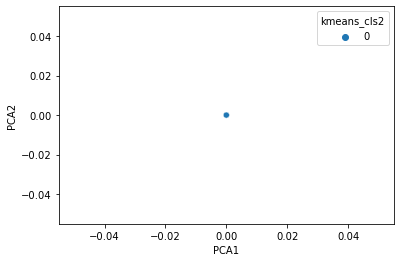

In [442]:
import seaborn as sns
sns.scatterplot(data=window_reads,x='PCA1',y='PCA2',hue='kmeans_cls2')